In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('../../')
import sklearn.datasets as datasets
from models import cmlp
from utility import fits

from sklearn.model_selection import train_test_split


In [2]:
X,Y =  datasets.make_moons(200, noise=0.5)
X.shape,Y.shape

((200, 2), (200,))

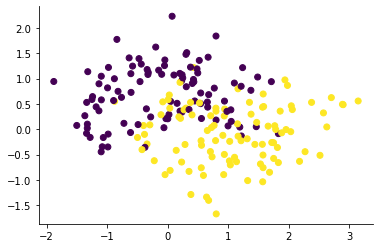

In [3]:
plt.scatter(X[:,0],X[:,1],c=Y)
sns.despine()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [16]:
model = cmlp.MLP([64,48])
params =  model.init(jax.random.PRNGKey(10),X_train)

In [17]:
params, loss = fits.fit(model, params, X_train, y_train,learning_rate=0.01, epochs=70, verbose=True)

Loss step 0:  0.6943218
Loss step 7:  0.36276272
Loss step 14:  0.33294535
Loss step 21:  0.31089318
Loss step 28:  0.30203354
Loss step 35:  0.2958749
Loss step 42:  0.29179582
Loss step 49:  0.28681728
Loss step 56:  0.28154305
Loss step 63:  0.27553496


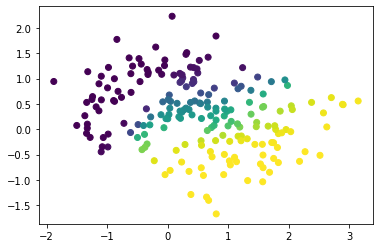

In [18]:
y_pred=model.apply(params,X_train)
y_pred_train_single=y_pred.reshape(134)
y_pred_test_single = model.apply(params,X_test).reshape(66)
plt.scatter(X_test[:,0],X_test[:,1],c=y_pred_test_single)
plt.scatter(X_train[:,0],X_train[:,1],c=y_pred)




In [19]:
from sklearn.metrics import brier_score_loss
brier_score_loss(y_train,y_pred_train_single),brier_score_loss(y_test,y_pred_test_single)


(0.09007161197286331, 0.12851206749373195)

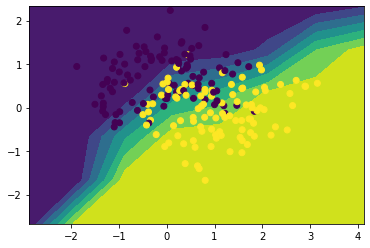

In [20]:
h=1

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))
Z =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.scatter(X[:,0],X[:,1],c=Y,alpha=1)
# plt.ylim(-1,1.4)

In [21]:
params_lst= []
loss_lst =[]

for i in range(5):
    params =  model.init(jax.random.PRNGKey(i),X)
    params,loss = fits.fit(model, params, X_train, y_train,learning_rate=0.01, epochs=70, verbose=False)
    params_lst.append(params)
    loss_lst.append(loss)

    

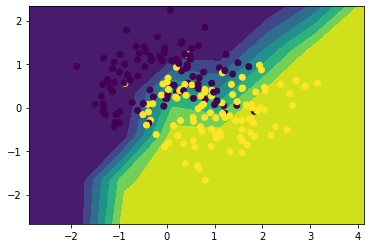

In [22]:
y_pred_grid_ensemble = []
for i in range(5):
    y_pred = model.apply(params,jnp.c_[xx.ravel(), yy.ravel()])
    y_pred_grid_ensemble.append(y_pred)
pred = jnp.array(y_pred_grid_ensemble).mean(axis=0)

Z = pred.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.scatter(X[:,0],X[:,1],c=Y,alpha=1)
# plt.ylim(-1,1.4)


In [23]:
y_pred_train_ensemble = []
y_pred_test_ensemble = []
for i in range(5):
    y_pred_ = model.apply(params_lst[i],X_train)
    y_pred_t = model.apply(params_lst[i],X_test)

    y_pred_train_ensemble.append(y_pred_)
    y_pred_test_ensemble.append(y_pred_t)
y_pred_train_ensemble = jnp.array(y_pred_train_ensemble).mean(axis=0)
y_pred_test_ensemble = jnp.array(y_pred_test_ensemble).mean(axis=0)


In [24]:
brier_score_loss(y_train,y_pred_train_ensemble),brier_score_loss(y_test,y_pred_test_ensemble)

(0.08814517056594763, 0.12580351834438094)

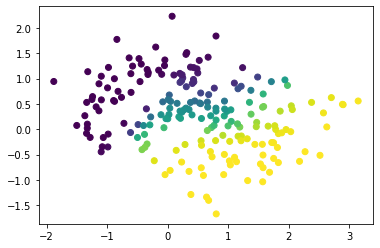

In [25]:
y_pred_train_ensemble=y_pred_train_ensemble.reshape(134)
y_pred_test_single =y_pred_test_ensemble.reshape(66)
plt.scatter(X_test[:,0],X_test[:,1],c=y_pred_test_ensemble)
plt.scatter(X_train[:,0],X_train[:,1],c=y_pred_train_ensemble)
